<font size=6>**Прогноз оттока клиентов**</font>

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

In [1]:
!pip install scikit-learn
!pip install phik
!pip install catboost

In [2]:
#импорт библиотек
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import phik
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost as cb
from sklearn.dummy import DummyClassifier


from sklearn.metrics import roc_auc_score

In [3]:
#задание стиля диаграмм
mpl.style.use(['Solarize_Light2'])

In [4]:
rand = 160224

# Предобработка данных

## Загрузка и первичная предобработка датасетов

### Договор

In [5]:
path_contract_01 = '/datasets/contract_new.csv'
path_contract_02 = 'https://code.s3.yandex.net/datasets/contract_new.csv'
path_contract_03 = 'C:\\Users\\User\\Desktop\\python\\final_project_vino\\datasets\\contract_new.csv'

In [6]:
try:
    if os.path.exists(path_contract_01):
        data_contract = pd.read_csv(path_contract_01)
    elif os.path.exists(path_contract_02):
        data_contract = pd.read_csv(path_contract_02)
    elif os.path.exists(path_contract_03):
        data_contract = pd.read_csv(path_contract_03)
    data_contract.info(memory_usage='deep')
    display(data_contract.head())
except:
    print('Возникла проблема при попытке загрузки датасета')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 3.1 MB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Из вывода info мы видим, что в датасете нет пропущенных значений.

В датасете 8 столбцов. Столбцы содержат следующую информацию о договорах:
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Видно, что столбцы BeginDate, EndDate, и TotalCharges имеют неправильные типы данных: object вместо date и float. Первый можно спокойно конвертировать.

In [7]:
data_contract['BeginDate'] = pd.to_datetime(data_contract['BeginDate'])
data_contract['BeginDate'].head(3)

0   2020-01-01
1   2017-04-01
2   2019-10-01
Name: BeginDate, dtype: datetime64[ns]

Теперь дата начала действия договора относится к типу datetime. Что касается окончания договора, то он фактически является нашим целевым признаком. Если точнее, из него этот признак можно извлечь: Значения 'No' будут означать 0, т.е. клиент ещё не разрывал договор, наличие даты означает 1 — договор был разорван.

In [8]:
def categorize(data):
    if data == 'No':
        return 0
    else:
        return 1

In [9]:
data_contract['IsBroken'] = data_contract['EndDate'].apply(categorize)
data_contract.head(3)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsBroken
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0


Целевой признак создан. Теперь стоит обратить внимание на Total_Charges, который автоматически определён как object, потому что все его значения представляют из себя строки. Исправим это: Уберём пробелы и заменим пустующие строки на 0, поскольку по этим договорам ещё не было внесёно информации об оплате.

In [10]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].str.replace(' ', '')
data_contract['TotalCharges'] = pd.to_numeric(data_contract['TotalCharges'], errors='coerce')
data_contract['TotalCharges'] = data_contract['TotalCharges'].fillna('0')

In [11]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].astype(float)
data_contract[['BeginDate', 'EndDate', 'MonthlyCharges','TotalCharges']].loc[data_contract['EndDate'] != 'No']

,BeginDate,EndDate,MonthlyCharges,TotalCharges
9,2014-12-01,2017-05-01,56.15,1628.35
15,2014-05-01,2016-03-01,113.25,2491.50
25,2017-08-01,2018-09-01,55.30,726.09
30,2014-03-01,2018-11-01,96.35,5395.60
35,2014-02-01,2018-12-01,99.90,5794.20
...,...,...,...,...
7004,2016-12-01,2019-02-01,95.10,2472.60
7005,2018-03-01,2019-12-01,19.30,433.67
7006,2016-09-01,2019-05-01,104.50,3344.00
7012,2014-12-01,2018-04-01,84.95,3737.80


### Интернет

In [12]:
path_internet_01 = '/datasets/internet_new.csv'
path_internet_02 = 'https://code.s3.yandex.net/datasets/internet_new.csv'
path_internet_03 = 'C:\\Users\\User\\Desktop\\python\\final_project_vino\\datasets\\internet_new.csv'

In [13]:
try:
    if os.path.exists(path_internet_01):
        data_internet = pd.read_csv(path_internet_01)
    elif os.path.exists(path_internet_02):
        data_internet = pd.read_csv(path_internet_02)
    elif os.path.exists(path_internet_03):
        data_internet = pd.read_csv(path_internet_03)
    data_internet.info(memory_usage='deep')
    display(data_internet.head())
except:
    print('Возникла проблема при попытке загрузки датасета')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 2.6 MB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


В данном датасете на первый взгляд нет проблем. Шесть столбцов в нём содержат бинарную информацию, которую позже мы трансформируем в численный вид.

Столбцы содержат следующую информацию:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

### Клиент

In [14]:
path_personal_01 = '/datasets/personal_new.csv'
path_personal_02 = 'https://code.s3.yandex.net/datasets/personal_new.csv'
path_personal_03 = 'C:\\Users\\User\\Desktop\\python\\final_project_vino\\datasets\\personal_new.csv'

In [15]:
try:
    if os.path.exists(path_personal_01):
        data_personal = pd.read_csv(path_personal_01)
    elif os.path.exists(path_personal_02):
        data_personal = pd.read_csv(path_personal_02)
    elif os.path.exists(path_personal_03):
        data_personal = pd.read_csv(path_personal_03)
    data_personal.info(memory_usage='deep')
    display(data_personal.head())
except:
    print('Возникла проблема при попытке загрузки датасета')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.7 MB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Вот описание признаков датасета о клиентах:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

### Телефон

In [16]:
path_phone_01 = '/datasets/phone_new.csv'
path_phone_02 = 'https://code.s3.yandex.net/datasets/phone_new.csv'
path_phone_03 = 'C:\\Users\\User\\Desktop\\python\\final_project_vino\\datasets\\phone_new.csv'

In [17]:
try:
    if os.path.exists(path_phone_01):
        data_phone = pd.read_csv(path_phone_01)
    elif os.path.exists(path_phone_02):
        data_phone = pd.read_csv(path_phonel_02)
    elif os.path.exists(path_phone_03):
        data_phone = pd.read_csv(path_phone_03)
    data_phone.info(memory_usage='deep')
    display(data_phone.head())
except:
    print('Возникла проблема при попытке загрузки датасета')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 785.7 KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Этот маленький датасет содержит всего два следующих столбца:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

### Промежуточный вывод

Я загрузила четыре датасета и изучила их. Преимущественно у нас здесь категориальные переменные, которые придётся дать численное представление. Это я сделаю после объединения датасетов по столбцу customerID.

## Объединение датасетов


Объединю датасеты по столбцу с идентификатором пользователя.

In [18]:
data = data_personal.merge(data_contract, how='left', on='customerID')
data = data.merge(data_internet, how='left', on='customerID')
data = data.merge(data_phone, how='left', on='customerID')
data = data.set_index('customerID')
data.info(memory_usage='deep')
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            7043 non-null   object        
 1   SeniorCitizen     7043 non-null   int64         
 2   Partner           7043 non-null   object        
 3   Dependents        7043 non-null   object        
 4   BeginDate         7043 non-null   datetime64[ns]
 5   EndDate           7043 non-null   object        
 6   Type              7043 non-null   object        
 7   PaperlessBilling  7043 non-null   object        
 8   PaymentMethod     7043 non-null   object        
 9   MonthlyCharges    7043 non-null   float64       
 10  TotalCharges      7043 non-null   float64       
 11  IsBroken          7043 non-null   int64         
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsBroken,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Male,0,No,No,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,0,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,Female,0,No,No,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,0,Fiber optic,No,No,No,No,No,No,No


### Анализ уходящих клиентов

Сгруппируем объекты по целевому признаку и посмотрим, какие клиенты чаще уходят, чем другие.

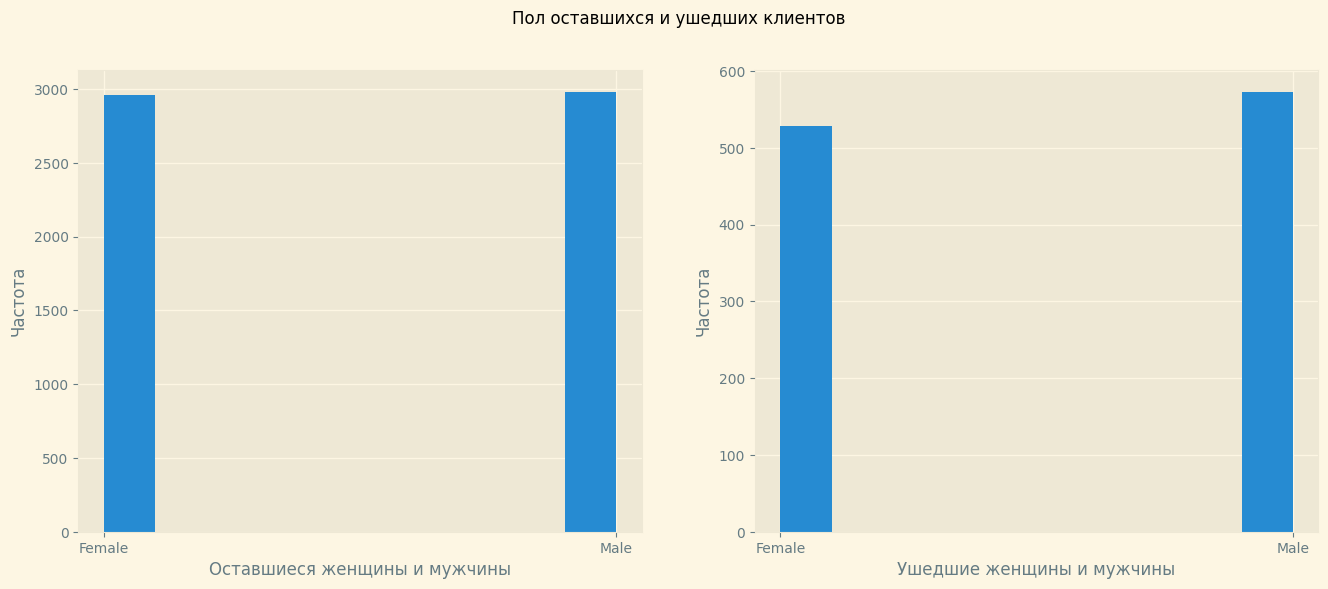

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Пол оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'gender'].sort_values())
axes[0].set_xlabel('Оставшиеся женщины и мужчины')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'gender'].sort_values())
axes[1].set_xlabel('Ушедшие женщины и мужчины')
axes[1].set_ylabel('Частота')
plt.show()

Благодаря балансу между этими двумя классами сразу видно, что разница между полами незначительная.

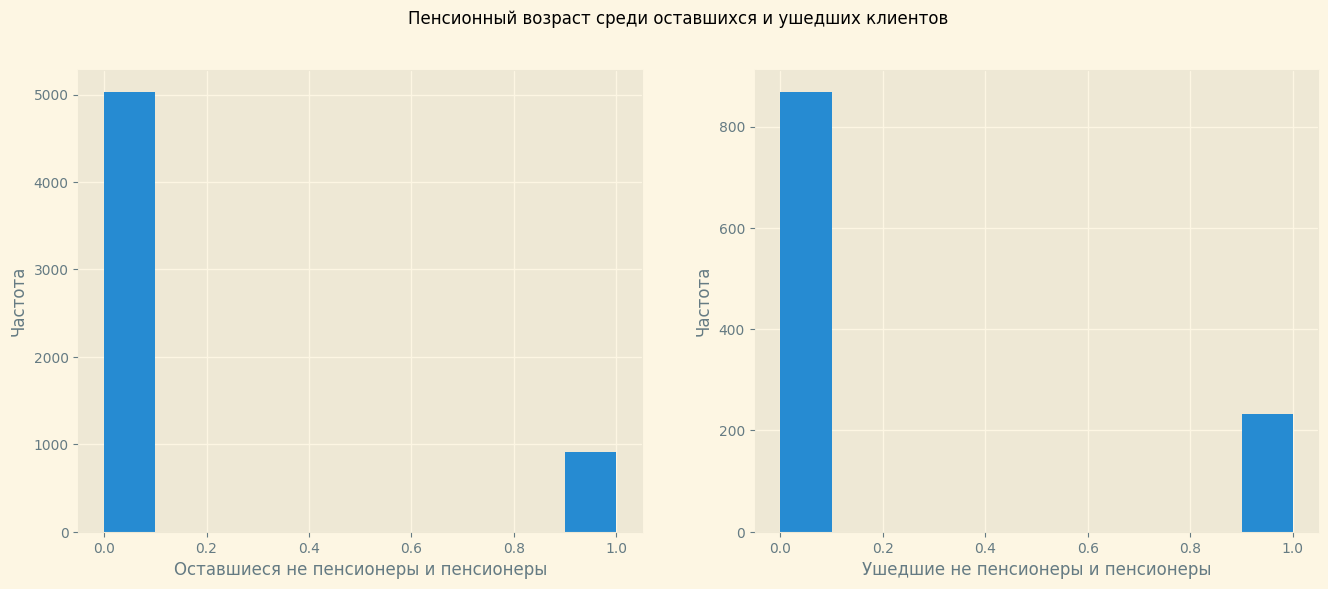

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Пенсионный возраст среди оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'SeniorCitizen'])
axes[0].set_xlabel('Оставшиеся не пенсионеры и пенсионеры')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'SeniorCitizen'])
axes[1].set_xlabel('Ушедшие не пенсионеры и пенсионеры')
axes[1].set_ylabel('Частота')
plt.show()

Тут также разница незначительна.

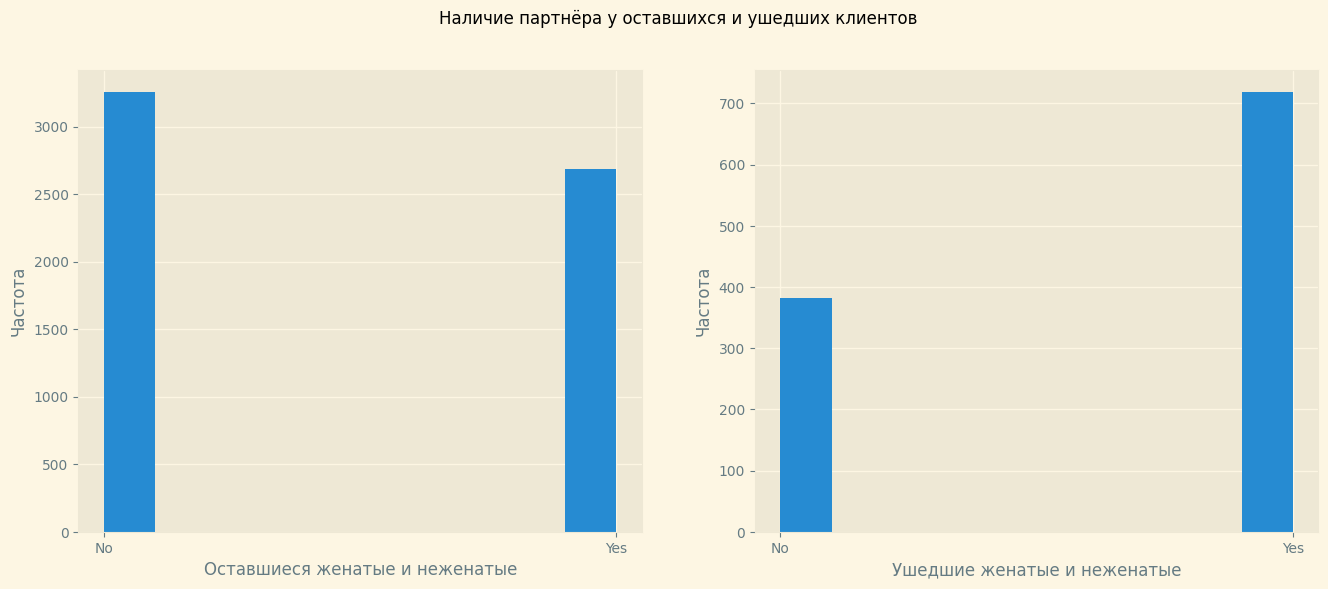

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Наличие партнёра у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'Partner'].sort_values())
axes[0].set_xlabel('Оставшиеся женатые и неженатые')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'Partner'].sort_values())
axes[1].set_xlabel('Ушедшие женатые и неженатые')
axes[1].set_ylabel('Частота')
plt.show()

Тут зависимость явно есть: ушедшие клиенты чаще женаты, чем нет.

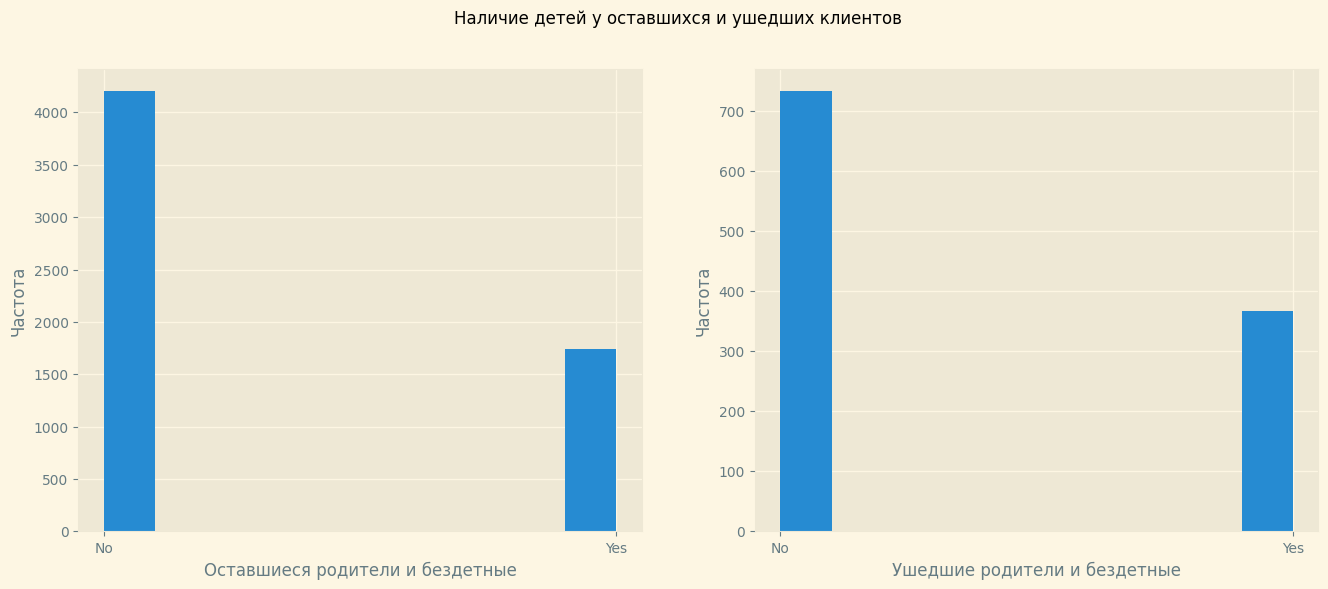

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Наличие детей у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'Dependents'].sort_values())
axes[0].set_xlabel('Оставшиеся родители и бездетные')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'Dependents'].sort_values())
axes[1].set_xlabel('Ушедшие родители и бездетные')
axes[1].set_ylabel('Частота')
plt.show()

Тут зависимость практически отсутствует.

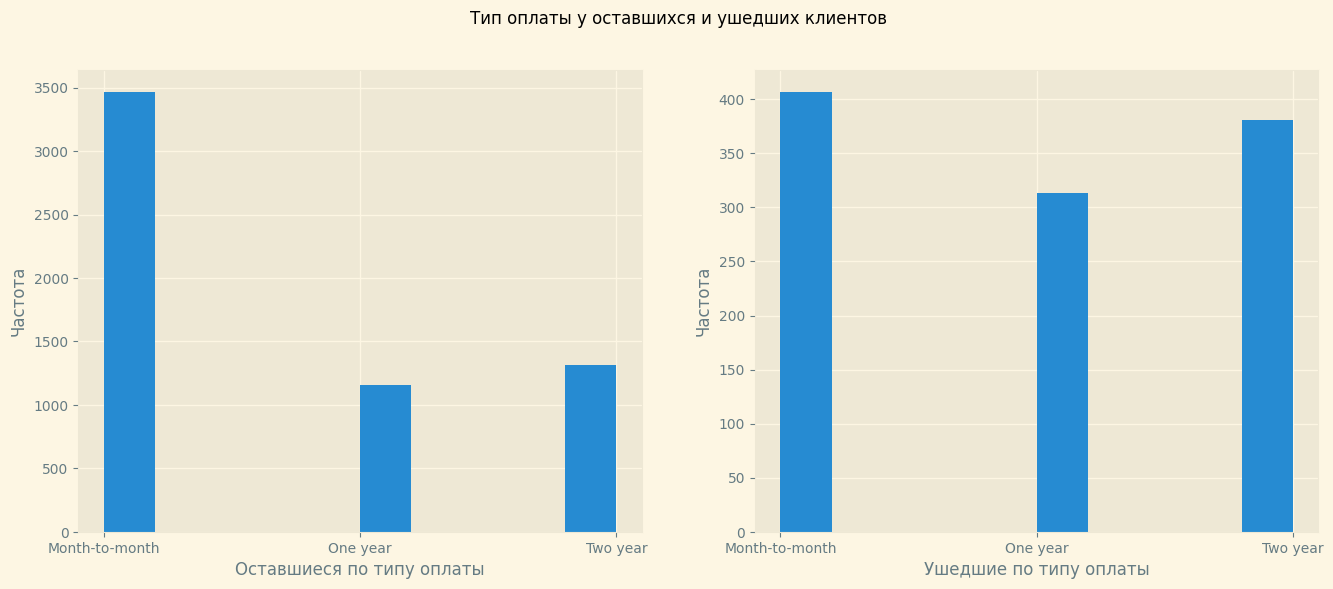

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Тип оплаты у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'Type'].sort_values())
axes[0].set_xlabel('Оставшиеся по типу оплаты')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'Type'].sort_values())
axes[1].set_xlabel('Ушедшие по типу оплаты')
axes[1].set_ylabel('Частота')
plt.show()

Оплачивающие  раз в месяц остаются чаще, а вот среди группы ушедших распределение более-менее равномерное.

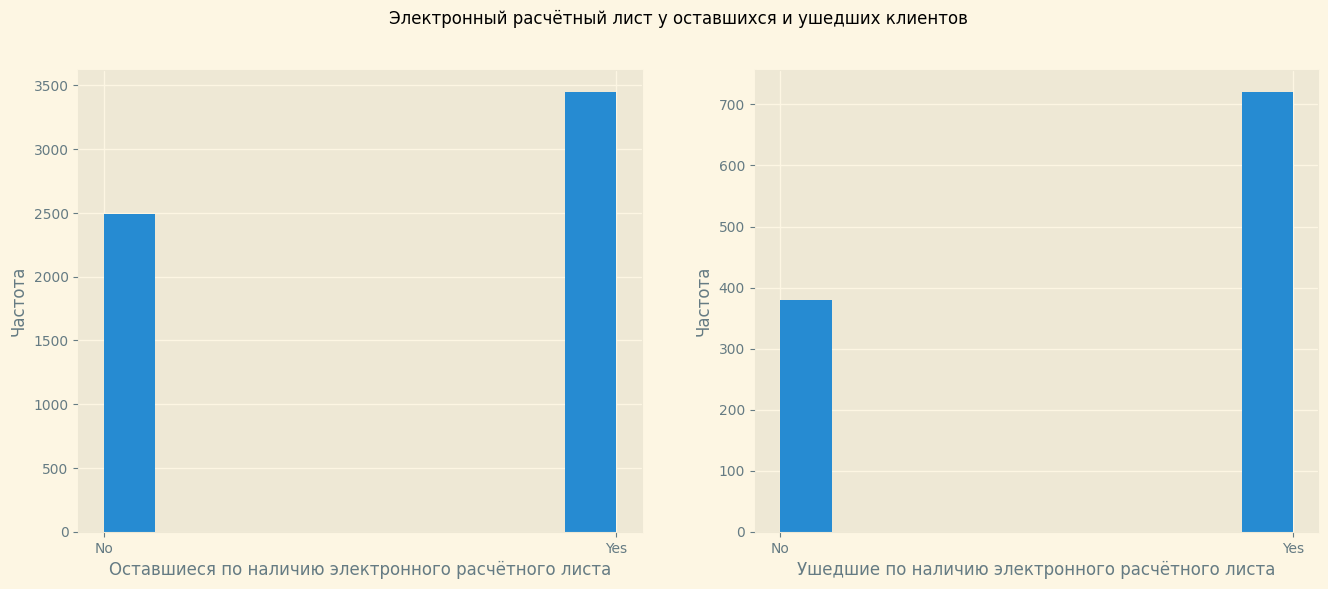

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Электронный расчётный лист у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'PaperlessBilling'].sort_values())
axes[0].set_xlabel('Оставшиеся по наличию электронного расчётного листа')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'PaperlessBilling'].sort_values())
axes[1].set_xlabel('Ушедшие по наличию электронного расчётного листа')
axes[1].set_ylabel('Частота')
plt.show()

Разница не большая.

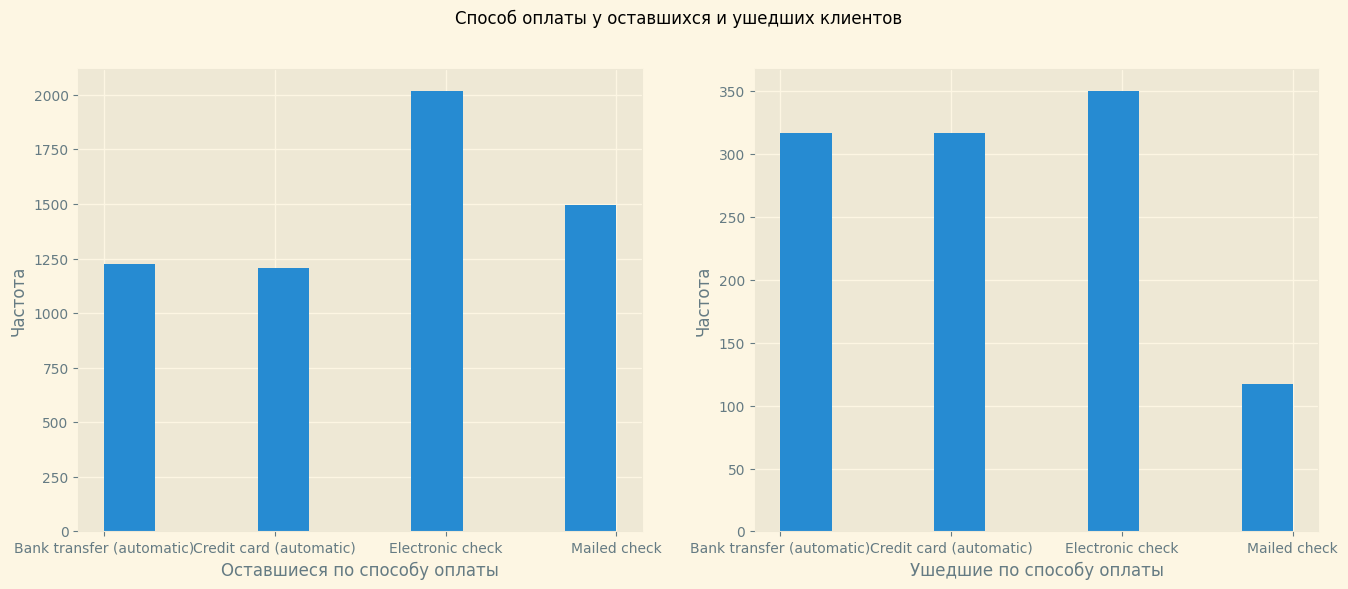

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Способ оплаты у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'PaymentMethod'].sort_values())
axes[0].set_xlabel('Оставшиеся по способу оплаты')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'PaymentMethod'].sort_values())
axes[1].set_xlabel('Ушедшие по способу оплаты')
axes[1].set_ylabel('Частота')
plt.show()

Среди ушедших мало кто пользуется почтовым чеком, предпочитая исключительно электронные способы.

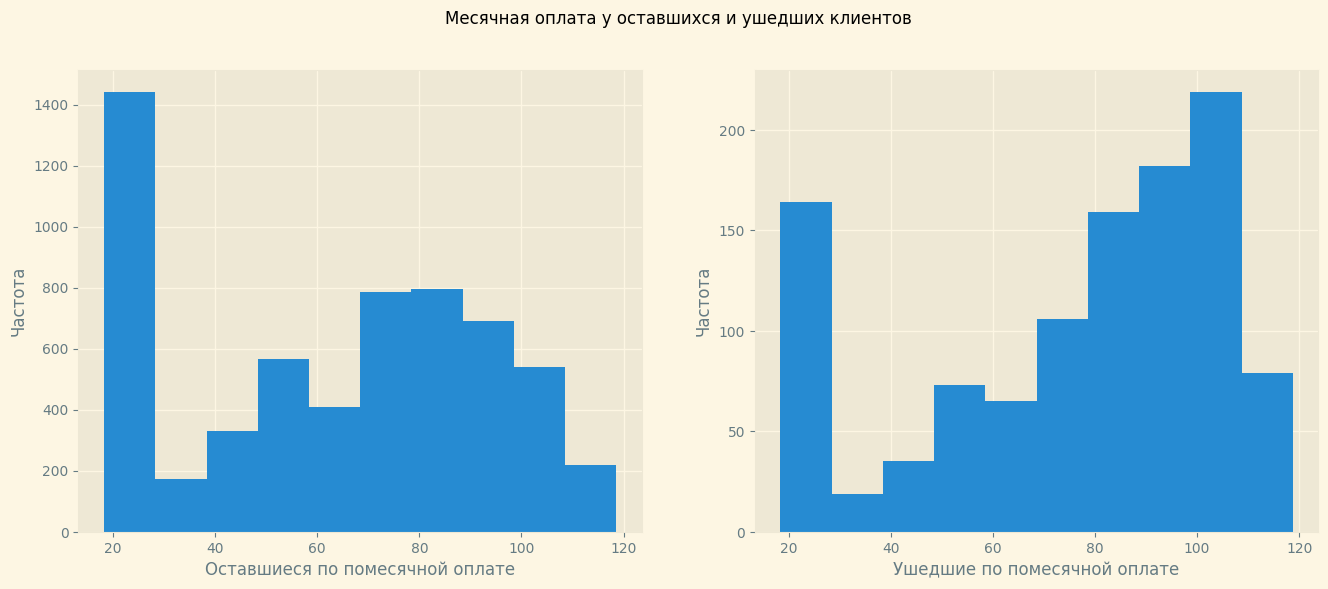

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Месячная оплата у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'MonthlyCharges'].sort_values())
axes[0].set_xlabel('Оставшиеся по помесячной оплате')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'MonthlyCharges'].sort_values())
axes[1].set_xlabel('Ушедшие по помесячной оплате')
axes[1].set_ylabel('Частота')
plt.show()

Среди ушедших имеется бОльшая склонность к высокой стоимости месяца.

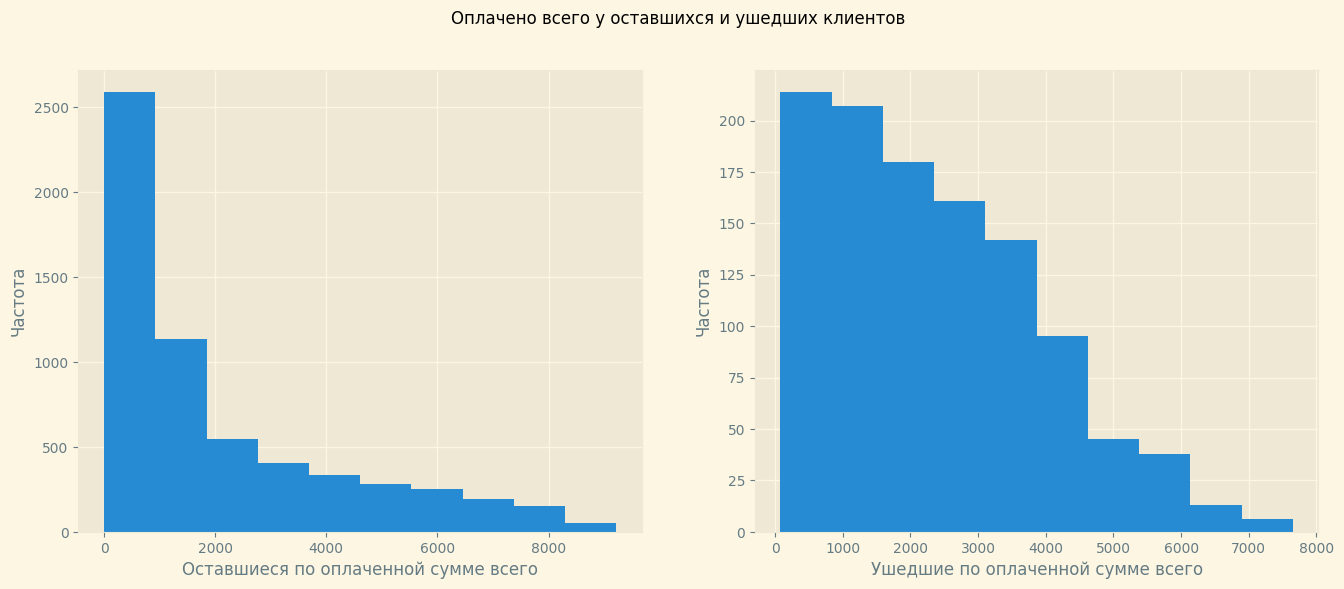

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Оплачено всего у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'TotalCharges'].sort_values())
axes[0].set_xlabel('Оставшиеся по оплаченной сумме всего')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'TotalCharges'].sort_values())
axes[1].set_xlabel('Ушедшие по оплаченной сумме всего')
axes[1].set_ylabel('Частота')
plt.show()

Среди ушедших ниже верхняя граница по оплаченому, но более плавное распределение в целом, в то время как у оставшихся имеется явный пик в начале и затем резкий спад.

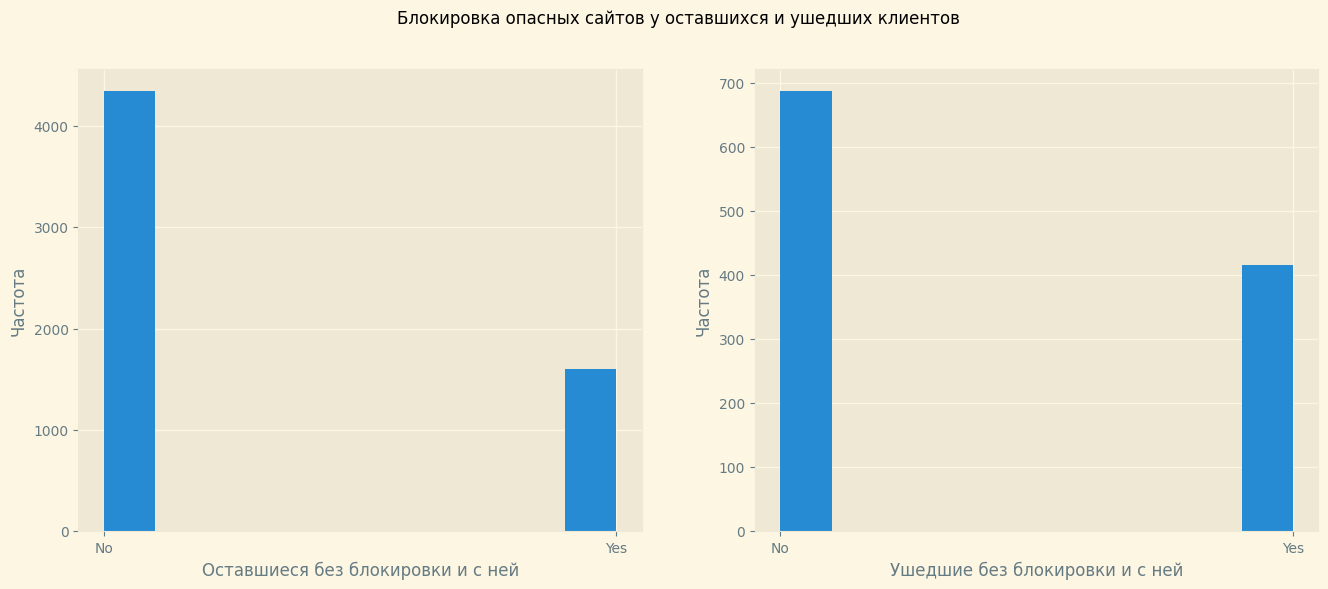

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Блокировка опасных сайтов у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'OnlineSecurity'].fillna('No').sort_values())
axes[0].set_xlabel('Оставшиеся без блокировки и с ней')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'OnlineSecurity'].fillna('No').sort_values())
axes[1].set_xlabel('Ушедшие без блокировки и с ней')
axes[1].set_ylabel('Частота')
plt.show()

Влияние выглядит небольшим по гистограммам.

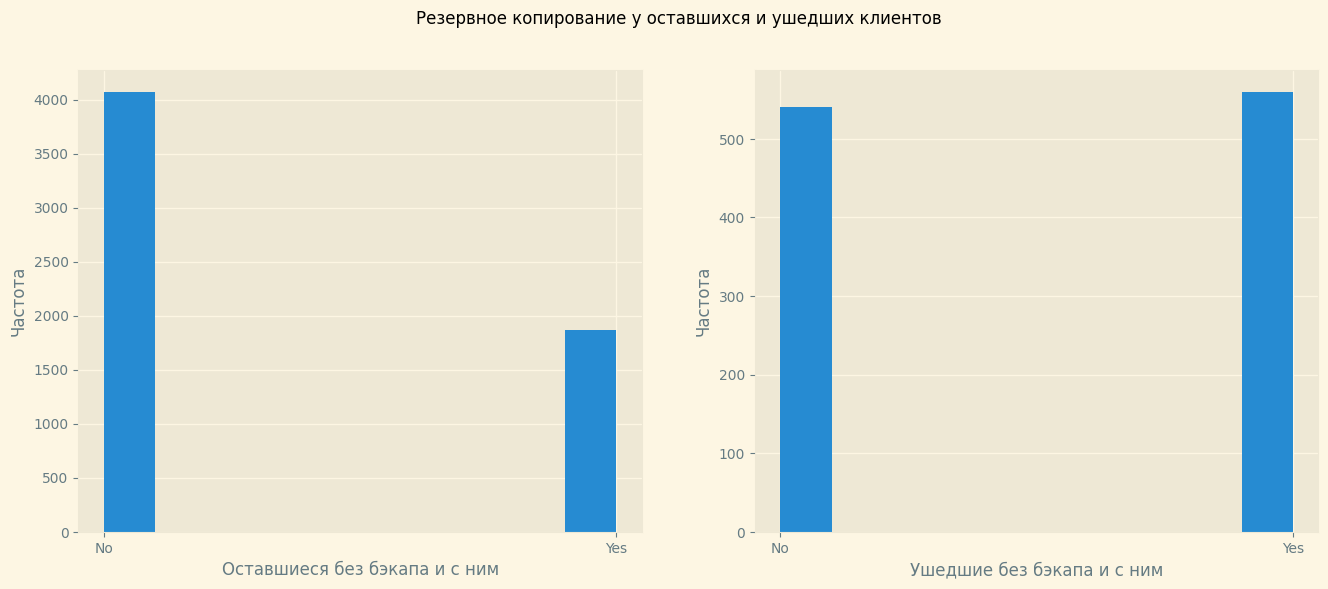

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Резервное копирование у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'OnlineBackup'].fillna('No').sort_values())
axes[0].set_xlabel('Оставшиеся без бэкапа и с ним')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'OnlineBackup'].fillna('No').sort_values())
axes[1].set_xlabel('Ушедшие без бэкапа и с ним')
axes[1].set_ylabel('Частота')
plt.show()

Тут разница заметна: среди оставшихся больше людей без подключённой услуги резервного копирования.

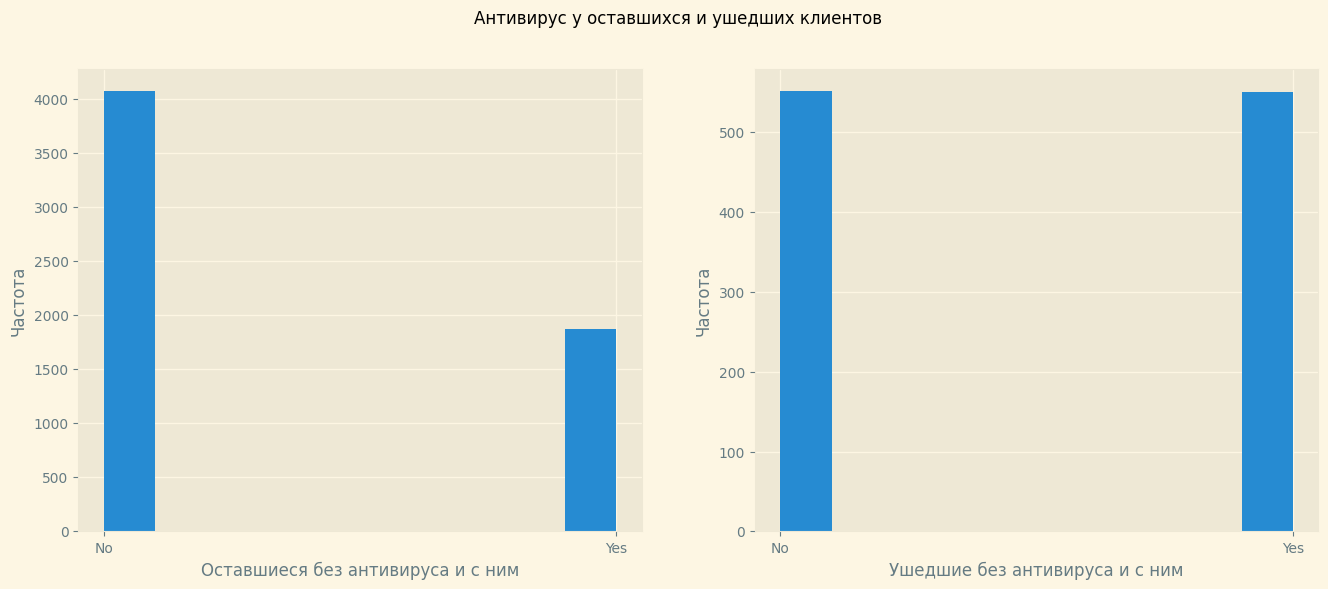

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Антивирус у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'DeviceProtection'].fillna('No').sort_values())
axes[0].set_xlabel('Оставшиеся без антивируса и с ним')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'DeviceProtection'].fillna('No').sort_values())
axes[1].set_xlabel('Ушедшие без антивируса и с ним')
axes[1].set_ylabel('Частота')
plt.show()

Здесь картина та же, что и у бэкапов.

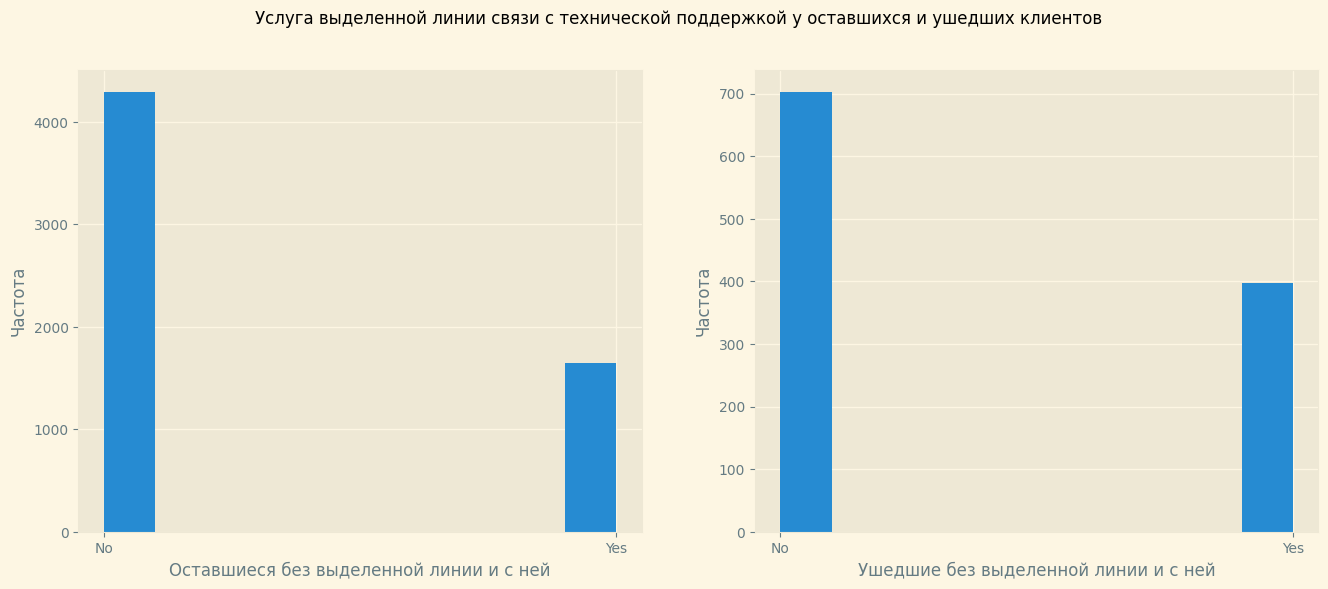

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Услуга выделенной линии связи с технической поддержкой у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'TechSupport'].fillna('No').sort_values())
axes[0].set_xlabel('Оставшиеся без выделенной линии и с ней')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'TechSupport'].fillna('No').sort_values())
axes[1].set_xlabel('Ушедшие без выделенной линии и с ней')
axes[1].set_ylabel('Частота')
plt.show()

Данный параметр практически не влияет на факт ухода клиента.

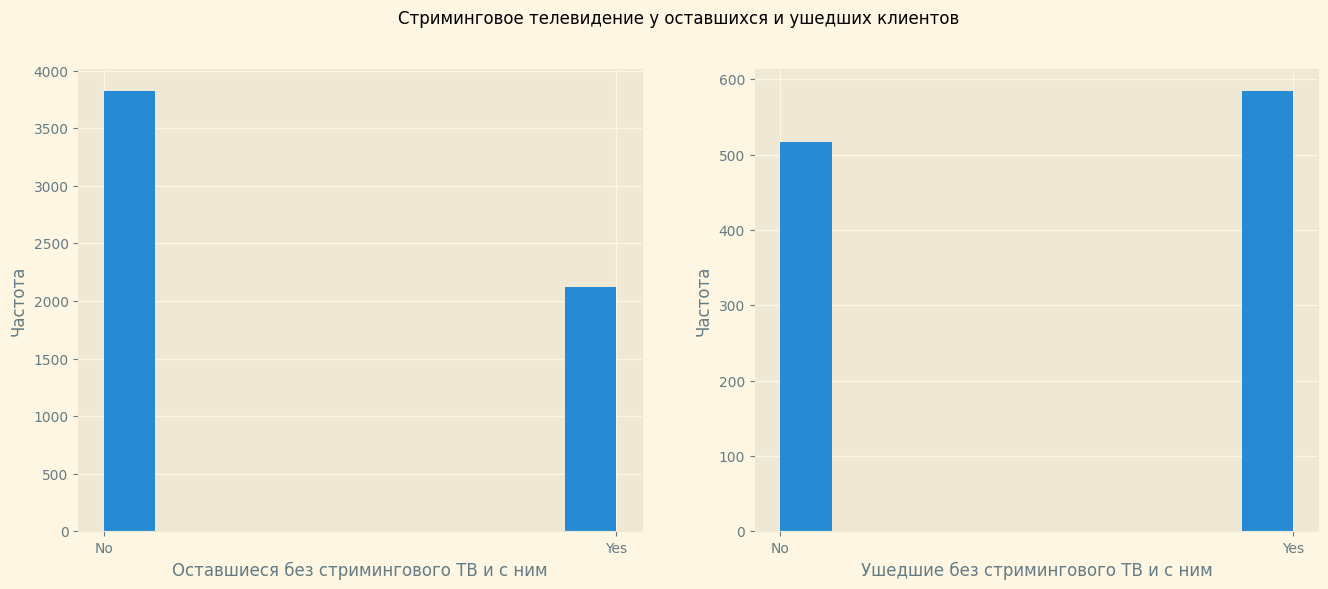

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Стриминговое телевидение у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'StreamingTV'].fillna('No').sort_values())
axes[0].set_xlabel('Оставшиеся без стримингового ТВ и с ним')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'StreamingTV'].fillna('No').sort_values())
axes[1].set_xlabel('Ушедшие без стримингового ТВ и с ним')
axes[1].set_ylabel('Частота')
plt.show()

Здесь зависимость есть, хотя и не слишком сильная.

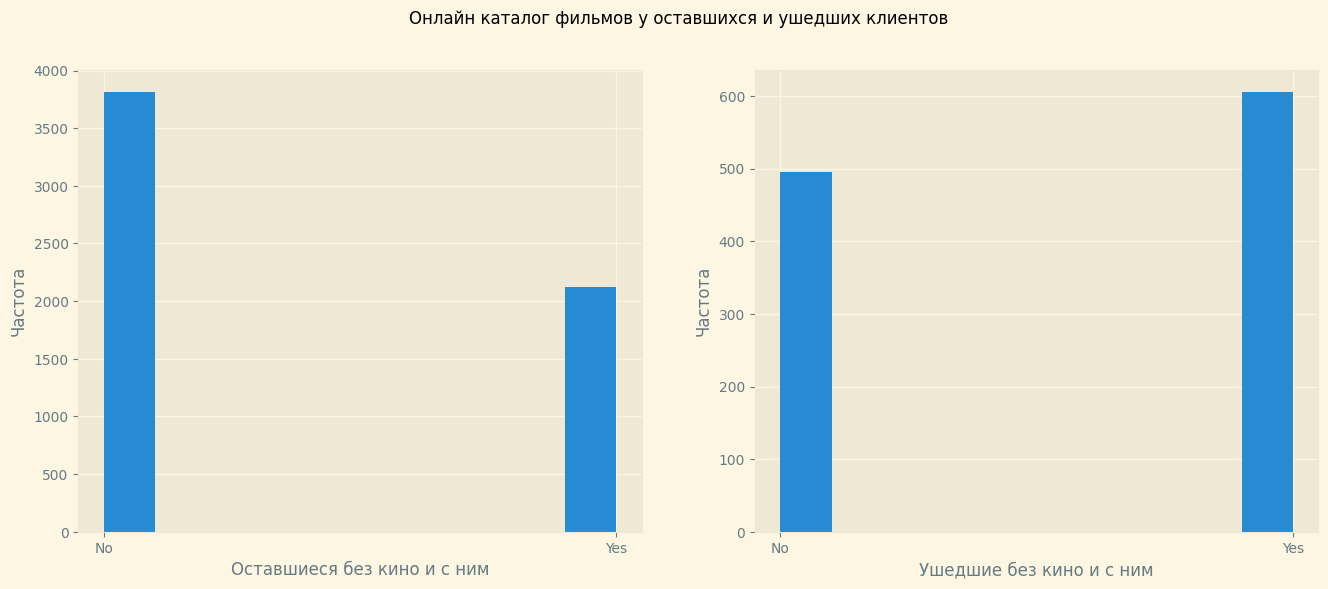

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Онлайн каталог фильмов у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'StreamingMovies'].fillna('No').sort_values())
axes[0].set_xlabel('Оставшиеся без кино и с ним')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'StreamingMovies'].fillna('No').sort_values())
axes[1].set_xlabel('Ушедшие без кино и с ним')
axes[1].set_ylabel('Частота')
plt.show()

С этим параметром картина та же, что и с подпиской на ТВ.

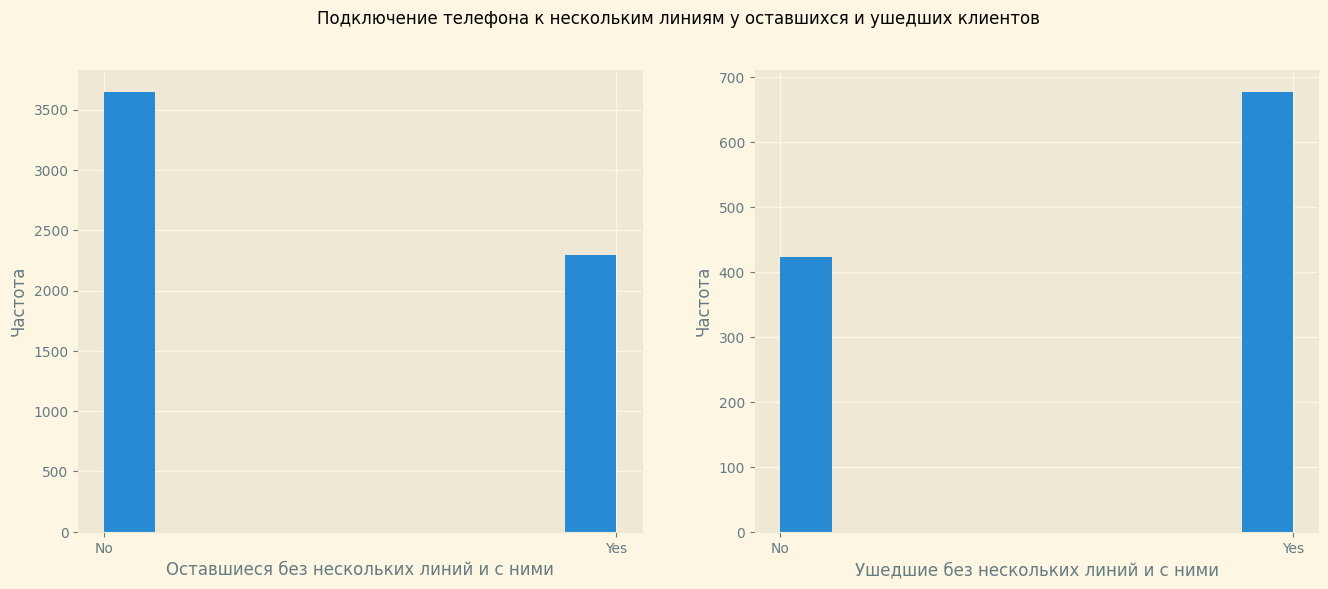

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Подключение телефона к нескольким линиям у оставшихся и ушедших клиентов')
axes[0].hist(data.loc[data['IsBroken'] == 0, 'MultipleLines'].fillna('No').sort_values())
axes[0].set_xlabel('Оставшиеся без нескольких линий и с ними')
axes[0].set_ylabel('Частота')
axes[1].hist(data.loc[data['IsBroken'] == 1, 'MultipleLines'].fillna('No').sort_values())
axes[1].set_xlabel('Ушедшие без нескольких линий и с ними')
axes[1].set_ylabel('Частота')
plt.show()

А вот тут зависимость уже внушительная.

По итогу визуального осмотра можно сделать вывод, что реальное влияние на целевой признак имеют: наличие партнёра, тип оплаты, оплата за месяц и за всё время, услуга резервного копирования, антивирус, стриминговые сервисы тв и кино, подключение телефона к нескольким линиям связи одновременно.

### Влияние на целевой признак
Для начала, удалим те столбцы, которые по умолчанию не влияют на целевой признак и будут нам только мешать. Это столбцы с датами начала и окончания договора. Но перед удалением выделим из них новый признак — длительность договора. Значения 'No' из столбца с датой окончания заменим на 2020-02-01 — это крайняя дата, фигурирующая в датасете.

In [35]:
data.loc[data['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
data['EndDate'] = pd.to_datetime(data['EndDate'])

In [36]:
data['Duration'] = data['EndDate'] - data['BeginDate']
data['Duration'] = pd.to_timedelta(data['Duration']).dt.days
data['Duration'].head(10)

customerID
7590-VHVEG      31
5575-GNVDE    1036
3668-QPYBK     123
7795-CFOCW    1371
9237-HQITU     153
9305-CDSKC     337
1452-KIOVK     671
6713-OKOMC     306
7892-POOKP     945
6388-TABGU     882
Name: Duration, dtype: int64

In [37]:
data = data.drop(['BeginDate', 'EndDate'], axis=1)

Теперь построим матрицу корреляции для оставшихся признаков.

In [38]:
data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges'])

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsBroken,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Duration
gender,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009025,0.000000,0.008581,0.000000,0.017842,0.003626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.000000,1.000000,0.016992,0.324576,0.086231,0.242133,0.292725,0.304691,0.135650,0.086159,0.309469,0.170667,0.000000,0.000000,0.209633,0.047996,0.075309,0.237594,0.142913
Partner,0.000000,0.016992,1.000000,0.652122,0.179736,0.013218,0.243008,0.203237,0.381958,0.226688,0.000000,0.265177,0.267471,0.290089,0.223082,0.239923,0.226459,0.232543,0.460087
Dependents,0.000000,0.324576,0.652122,1.000000,0.147680,0.172593,0.224903,0.184213,0.084247,0.046871,0.206200,0.244955,0.150651,0.131018,0.212178,0.080593,0.030894,0.035777,0.223641
Type,0.000000,0.086231,0.179736,0.147680,1.000000,0.106860,0.277462,0.388266,0.470860,0.094015,0.115464,0.253529,0.195386,0.247180,0.293239,0.163095,0.167051,0.071275,0.764608
PaperlessBilling,0.000000,0.242133,0.013218,0.172593,0.106860,1.000000,0.370495,0.467783,0.201703,0.083398,0.363514,0.215271,0.000000,0.029758,0.135913,0.182356,0.155905,0.269304,0.078497
PaymentMethod,0.000000,0.292725,0.243008,0.224903,0.277462,0.370495,1.000000,0.399536,0.335666,0.214832,0.434448,0.365104,0.269205,0.297768,0.372982,0.247449,0.255010,0.369809,0.466171
MonthlyCharges,0.009025,0.304691,0.203237,0.184213,0.388266,0.467783,0.399536,1.000000,0.711035,0.225925,0.948738,0.364891,0.428024,0.495800,0.402669,0.733083,0.727985,0.475869,0.423107
TotalCharges,0.000000,0.135650,0.381958,0.084247,0.470860,0.201703,0.335666,0.711035,1.000000,0.302890,0.301728,0.411771,0.514493,0.538299,0.444493,0.526653,0.525316,0.580930,0.835671
IsBroken,0.008581,0.086159,0.226688,0.046871,0.094015,0.083398,0.214832,0.225925,0.302890,1.000000,0.098956,0.107962,0.218638,0.205516,0.073561,0.182185,0.208651,0.283076,0.928032


Нас интересуют только признаки, у которых корреляция с IsBroken выше хотя бы 0.1: остальные не оказывают никакого влияния и только создают шум.

In [39]:
data = data[['IsBroken', 'Partner', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'MultipleLines', 'Duration']]
data.head()

,IsBroken,Partner,PaymentMethod,MonthlyCharges,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,MultipleLines,Duration
customerID,,,,,,,,,,,
7590-VHVEG,0,Yes,Electronic check,29.85,31.04,No,Yes,No,No,NaN,31
5575-GNVDE,0,No,Mailed check,56.95,2071.84,Yes,No,Yes,No,No,1036
3668-QPYBK,0,No,Mailed check,53.85,226.17,Yes,Yes,No,No,No,123
7795-CFOCW,0,No,Bank transfer (automatic),42.30,1960.60,Yes,No,Yes,No,NaN,1371
9237-HQITU,0,No,Electronic check,70.70,353.50,No,No,No,No,No,153


### Обработка пропущенных значений

После объединения в нашем датасете неизбежно образовались попущенные значения.

In [40]:
data.isna().sum()

IsBroken               0
Partner                0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
StreamingTV         1526
MultipleLines        682
Duration               0
dtype: int64

Эти столбцы хранят значения 'Yes' или 'No' для определения, есть ли у клиента та или иная услуга. Думаю, достаточно безопасно заявить, что отсутствие информации об услуге говорит об отсутствии самой услуги, потому все nan заменим на 'No'.

In [41]:
data = data.fillna('No')
data.isna().sum()

IsBroken            0
Partner             0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
StreamingTV         0
MultipleLines       0
Duration            0
dtype: int64

### Выделение выборок, фичей и таргета

In [42]:
features = data.drop(['IsBroken'], axis=1)
target = data['IsBroken']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state=rand)
print('features_train.shape', features_train.shape, 'target_train.shape', target_train.shape)
print('features_test.shape', features_test.shape, 'target_test.shape', target_test.shape)

features_train.shape (5282, 10) target_train.shape (5282,)
features_test.shape (1761, 10) target_test.shape (1761,)


### Кодирование категориальных признаков

In [43]:
cat = features_train.drop(['MonthlyCharges', 'TotalCharges', 'Duration'], axis=1).columns
oe = OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value')
features_train[cat] = oe.fit_transform(features_train[cat])
features_test[cat] = oe.transform(features_test[cat])
display(features_train.head())
display(features_test.head())

,Partner,PaymentMethod,MonthlyCharges,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,MultipleLines,Duration
customerID,,,,,,,,,,
8314-HTWVE,1.0,3.0,19.85,152.85,0.0,0.0,0.0,0.0,0.0,215
8148-NLEGT,1.0,2.0,22.95,849.15,0.0,0.0,0.0,0.0,1.0,1126
9818-XQCUV,0.0,3.0,20.35,40.70,0.0,0.0,0.0,0.0,0.0,62
2823-LKABH,0.0,0.0,95.05,1728.01,0.0,0.0,1.0,0.0,1.0,549
6549-YMFAW,1.0,3.0,21.25,191.25,0.0,0.0,0.0,0.0,0.0,276


,Partner,PaymentMethod,MonthlyCharges,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,MultipleLines,Duration
customerID,,,,,,,,,,
9348-YVOMK,0.0,1.0,44.80,179.20,0.0,0.0,0.0,0.0,0.0,123
5366-IJEQJ,0.0,2.0,88.70,2299.10,0.0,0.0,1.0,1.0,1.0,730
1402-PTHGN,1.0,3.0,61.50,1173.42,1.0,1.0,0.0,0.0,0.0,549
5377-NDTOU,1.0,3.0,91.05,6464.55,1.0,1.0,1.0,1.0,1.0,2163
4091-TVOCN,0.0,1.0,78.75,3931.20,1.0,0.0,1.0,1.0,1.0,1461


### Скалирование количественных признаков

In [44]:
col = ['MonthlyCharges', 'TotalCharges', 'Duration']
ss = StandardScaler()
features_train[col] = ss.fit_transform(features_train[col])
features_test[col] = ss.transform(features_test[col])
display(features_train.head())
display(features_test.head())

,Partner,PaymentMethod,MonthlyCharges,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,MultipleLines,Duration
customerID,,,,,,,,,,
8314-HTWVE,1.0,3.0,-1.485264,-0.929806,0.0,0.0,0.0,0.0,0.0,-1.008280
8148-NLEGT,1.0,2.0,-1.382740,-0.601647,0.0,0.0,0.0,0.0,1.0,0.329518
9818-XQCUV,0.0,3.0,-1.468728,-0.982661,0.0,0.0,0.0,0.0,0.0,-1.232959
2823-LKABH,0.0,0.0,1.001783,-0.187451,0.0,0.0,1.0,0.0,1.0,-0.517803
6549-YMFAW,1.0,3.0,-1.438963,-0.911708,0.0,0.0,0.0,0.0,0.0,-0.918702


,Partner,PaymentMethod,MonthlyCharges,TotalCharges,OnlineSecurity,OnlineBackup,DeviceProtection,StreamingTV,MultipleLines,Duration
customerID,,,,,,,,,,
9348-YVOMK,0.0,1.0,-0.660107,-0.917387,0.0,0.0,0.0,0.0,0.0,-1.143381
5366-IJEQJ,0.0,2.0,0.791773,0.081698,0.0,0.0,1.0,1.0,1.0,-0.252006
1402-PTHGN,1.0,3.0,-0.107797,-0.448823,1.0,1.0,0.0,0.0,0.0,-0.517803
5377-NDTOU,1.0,3.0,0.869493,2.044827,1.0,1.0,1.0,1.0,1.0,1.852345
4091-TVOCN,0.0,1.0,0.462702,0.850888,1.0,0.0,1.0,1.0,1.0,0.821463


## Промежуточный вывод

В разделе предобработки данных, я:
- Загрузила предоставленные датасеты, изучила их и сделала необходимую предобработку;
- Объединила их в один датасет;
- Удалила не оказывающие влияния на целевой признак столбцы;
- Обработала пропущенные значения;
- Методом апскейлинга обработала дисбаланс классов;
- Выделила тестовую выборку, отделила целевой признак от остальных;
- Закодировала категориальные переменные и скалировала численные.

# Обучение и выбор модели

## Дерево решений

In [45]:
model = DecisionTreeClassifier(random_state=rand, class_weight='balanced')
params = {'criterion': ['gini','entropy', 'log_loss'],
          'max_depth': range(1, 11)}
search = GridSearchCV(model, params, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)
print('Лучший результат решающего дерева:', search.best_score_, 'при следующих параметрах:', search.best_params_)

Лучший результат решающего дерева: 0.7653982714149048 при следующих параметрах: {'criterion': 'gini', 'max_depth': 5}


## Логистическая регрессия

In [46]:
model = LogisticRegression(random_state=rand, class_weight='balanced')
params = {'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}
search = GridSearchCV(model, params, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)
print('Лучший результат логистической регрессии:', search.best_score_, 'при следующих параметрах:', search.best_params_)

Лучший результат логистической регрессии: 0.7302527369775135 при следующих параметрах: {'solver': 'newton-cg'}


## K-ближайших соседей

In [47]:
model = KNeighborsClassifier()
params = {'weights' : ['uniform', 'distance'],
          'n_neighbors': [1, 3, 5, 10, 30, 50, 100]}
search = GridSearchCV(model, params, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)
print('Лучший результат модели kNN:', search.best_score_, 'при следующих параметрах:', search.best_params_)

Лучший результат модели kNN: 0.7925059096353487 при следующих параметрах: {'n_neighbors': 100, 'weights': 'uniform'}


## Случайный лес

In [48]:
model = RandomForestClassifier(random_state=rand, class_weight='balanced')
params = {'max_depth': [5, 10, 20],
          'min_samples_leaf': [1, 5, 10],
          'n_estimators': [50, 100, 200, 500]}
search = GridSearchCV(model, params, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)
print('Лучший результат модели случайного леса:', search.best_score_, 'при следующих параметрах:', search.best_params_)

Лучший результат модели случайного леса: 0.8047803446269821 при следующих параметрах: {'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 500}


## Градиентный бустинг

In [49]:
model = cb.CatBoostClassifier(random_state=rand, auto_class_weights='Balanced')
params = {'learning_rate': [0.01, 0.1, 1],
          'n_estimators': [200, 500, 1000],
          'l2_leaf_reg': [3, 6, 9]}
search = GridSearchCV(model, params, cv=5)
search.fit(features_train, target_train)
print('Лучший результат модели градиентного бустинга:', search.best_score_, 'при следующих параметрах:', search.best_params_)

Выходные данные были обрезаны до нескольких последних строк (5000).
1:	learn: 0.5323460	total: 5.22ms	remaining: 2.61s
2:	learn: 0.5089532	total: 7.68ms	remaining: 2.55s
3:	learn: 0.5018838	total: 10.1ms	remaining: 2.52s
4:	learn: 0.4882778	total: 12.6ms	remaining: 2.5s
5:	learn: 0.4829236	total: 15ms	remaining: 2.49s
6:	learn: 0.4709181	total: 17.5ms	remaining: 2.49s
7:	learn: 0.4640192	total: 20.4ms	remaining: 2.53s
8:	learn: 0.4545474	total: 23.2ms	remaining: 2.55s
9:	learn: 0.4479062	total: 26ms	remaining: 2.58s
10:	learn: 0.4401103	total: 28.7ms	remaining: 2.58s
11:	learn: 0.4318261	total: 31.5ms	remaining: 2.59s
12:	learn: 0.4175782	total: 34.3ms	remaining: 2.61s
13:	learn: 0.4114638	total: 37.2ms	remaining: 2.62s
14:	learn: 0.4005812	total: 40.2ms	remaining: 2.64s
15:	learn: 0.3920210	total: 43ms	remaining: 2.64s
16:	learn: 0.3827524	total: 45.5ms	remaining: 2.63s
17:	learn: 0.3746463	total: 48ms	remaining: 2.62s
18:	learn: 0.3674476	total: 50.6ms	remaining: 2.61s
19:	learn: 0.3

Из пяти обученных и проверенных на кросс-валидации моделей k-ближайших соседей показывает самый лучший результат AUC-ROC со значительным отрывом.

# Проверка модели

In [50]:
model = cb.CatBoostClassifier(random_state=rand, auto_class_weights='Balanced', l2_leaf_reg=3, learning_rate=0.1, n_estimators=1000)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
proba = model.predict_proba(features_test)
auc = roc_auc_score(target_test, proba[:,1])
print('AUC-ROC на тестовой выборке =', auc)

0:	learn: 0.6681087	total: 6.74ms	remaining: 6.73s
1:	learn: 0.6432184	total: 14.2ms	remaining: 7.08s
2:	learn: 0.6234623	total: 21.6ms	remaining: 7.19s
3:	learn: 0.6109946	total: 27.7ms	remaining: 6.89s
4:	learn: 0.5985106	total: 30.5ms	remaining: 6.07s
5:	learn: 0.5848564	total: 34.6ms	remaining: 5.74s
6:	learn: 0.5743090	total: 37.8ms	remaining: 5.36s
7:	learn: 0.5651399	total: 41.2ms	remaining: 5.11s
8:	learn: 0.5598568	total: 44ms	remaining: 4.84s
9:	learn: 0.5541444	total: 46.6ms	remaining: 4.61s
10:	learn: 0.5475063	total: 49.3ms	remaining: 4.44s
11:	learn: 0.5444998	total: 52.1ms	remaining: 4.29s
12:	learn: 0.5408279	total: 54.7ms	remaining: 4.15s
13:	learn: 0.5351259	total: 57.7ms	remaining: 4.06s
14:	learn: 0.5348446	total: 59.6ms	remaining: 3.92s
15:	learn: 0.5300712	total: 62.6ms	remaining: 3.85s
16:	learn: 0.5258161	total: 65.6ms	remaining: 3.79s
17:	learn: 0.5233256	total: 68.5ms	remaining: 3.73s
18:	learn: 0.5204278	total: 71.4ms	remaining: 3.69s
19:	learn: 0.5174138	tot

Сравним с константной моделью, выбирающей популярный класс.

In [51]:
model_dummy = DummyClassifier()
model_dummy.fit(features_train, target_train)
predictions = model_dummy.predict(features_test)
auc = roc_auc_score(target_test, predictions)
print('AUC-ROC константной модели =', auc)

AUC-ROC константной модели = 0.5


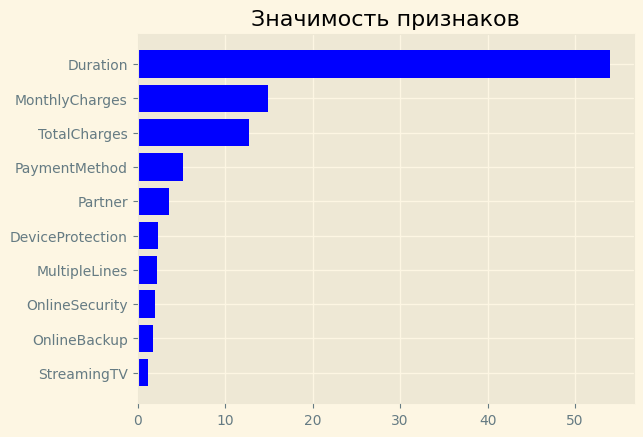

In [52]:
feature_names = features_train.columns
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)

plt.title('Значимость признаков')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.show()

# Вывод

В данном проекте по машинному обучению я сделала следующее:

- Загрузила предоставленные датасеты;
- Изучила их и провела необходимую предобработку;
- Объединила по идентификатору пользователя и установила его в качестве id для объединённого датасета;
- Определила влияние на целевой признак и отсеяла не нужные признаки;
- Устранила дисбаланс классов используя апсэмплинг;
- Обработала образовавшиеся после объединения пропуски;
- Выделила выборки, отделила целевой признак от остальных;
- Кодировала категориальные признаки;
- Скалировала вещественные признаки;
- Обучила пять моделей: решающее дерево, логистическую регрессию, k-ближайших соседей, случайный лес и градиентный бустинг. Из них все, кроме логистической регрессии с перебором гиперпараметров;
- Сравнила их на кросс-валидации с использованием метрики AUC-ROC;
- Выбрала лучшую и проверила её на тестовой выборке со сравнением с константной моделью, выбирающей наиболее частый класс.

В результате сравнения, мною была выбрана модель градиентного бустинга из библиотеки CatBoost. На тестовой выборке она показала AUC-ROC 0.93, что на 0.43 выше, чем результат константной модели.

Уже на текущем этапе модель должна приемлемо справляться с поставленной бизнесом задачей. Для дальнейшего улучшения результата, можно попробовать собрать больше информации об абонентах (допустим, возраст или трудовой стаж) и доработать алгоритм бустинга, подобрав лучшие гиперпараметры.